<a href="https://colab.research.google.com/github/KissTK322/Ai-Builder-2023/blob/main/Klachalarjai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libary

In [ ]:
import os
import os.path as op
import shutil
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from torchvision import datasets , models , transforms
from torch.utils.data import DataLoader 
from sklearn.model_selection import train_test_split
from PIL import Image

#ดู path ของรูป

In [ ]:
glob("/content/drive/MyDrive/Chula-ParasiteEgg-11/Chula-ParasiteEgg-11/data/*.jpg")[0 : 100]

'/content/drive/MyDrive/Chula-ParasiteEgg-11/Chula-ParasiteEgg-11/data/Capillaria philippinensis_0216.jpg'

#เอารูปออกมาดู

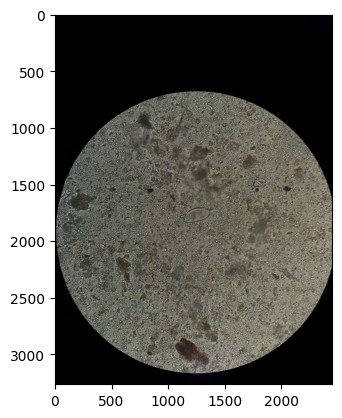

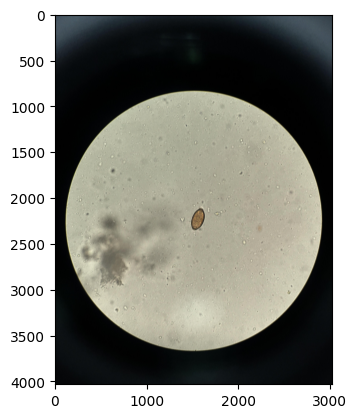

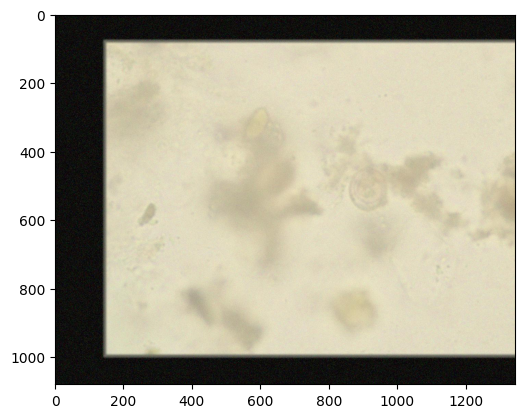

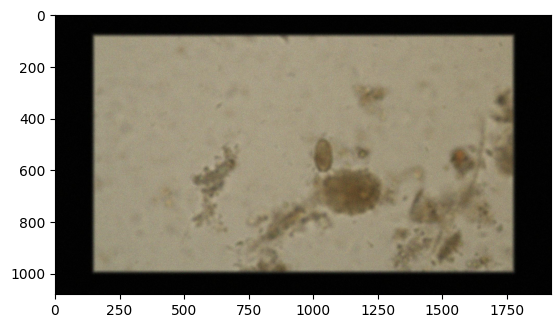

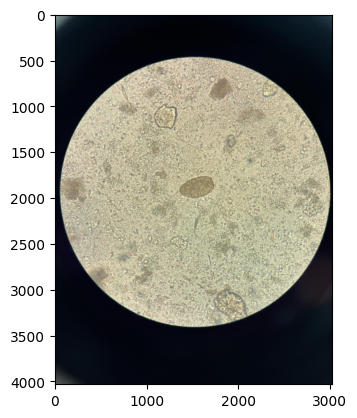

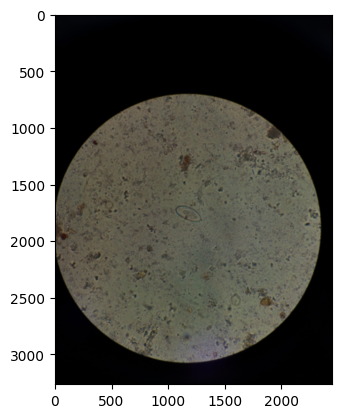

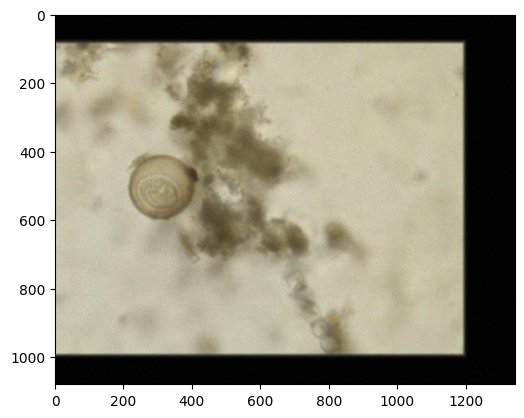

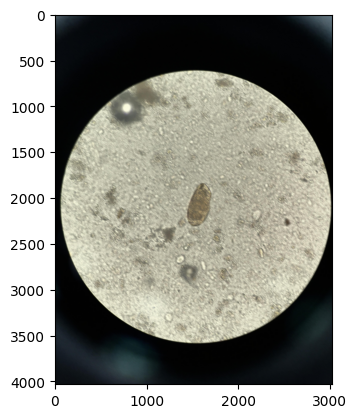

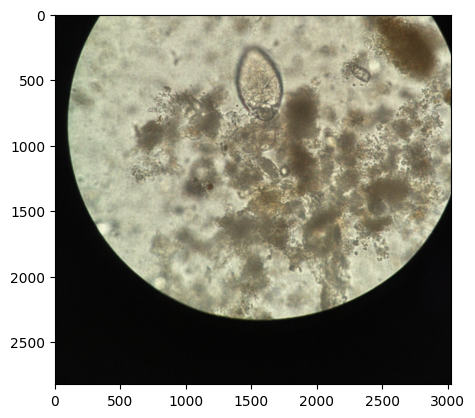

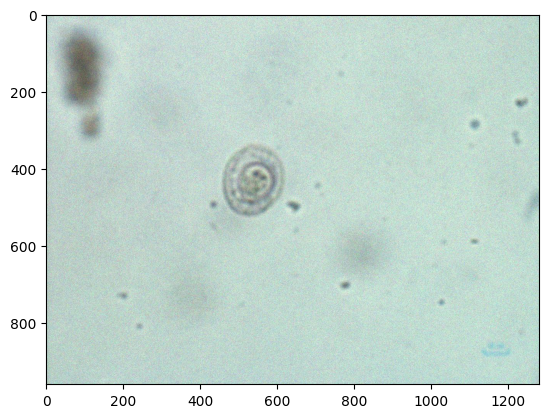

In [ ]:

for i in glob("/content/drive/MyDrive/Chula-ParasiteEgg-11/Chula-ParasiteEgg-11/data/*.jpg")[0 : 10] : 
  plt.imshow(Image.open(i))
  plt.show()


#New

In [ ]:
!apt-get --purge remove cuda nvidia* libnvidia-*
!dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
!apt-get remove cuda-*
!apt autoremove
!apt-get update

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'nvidia-kernel-common-418-server' for glob 'nvidia*'
Note, selecting 'nvidia-325-updates' for glob 'nvidia*'
Note, selecting 'nvidia-346-updates' for glob 'nvidia*'
Note, selecting 'nvidia-driver-binary' for glob 'nvidia*'
Note, selecting 'nvidia-331-dev' for glob 'nvidia*'
Note, selecting 'nvidia-compute-utils-418-server' for glob 'nvidia*'
Note, selecting 'nvidia-384-dev' for glob 'nvidia*'
Note, selecting 'nvidia-docker2' for glob 'nvidia*'
Note, selecting 'nvidia-headless-525-server' for glob 'nvidia*'
Note, selecting 'nvidia-headless-530-open' for glob 'nvidia*'
Note, selecting 'nvidia-fs-prebuilt' for glob 'nvidia*'
Note, selecting 'nvidia-driver-530-open' for glob 'nvidia*'
Note, selecting 'nvidia-driver-440-server' for glob 'nvidia*'
Note, selecting 'nvidia-dkms-450-server' for glob 'nvidia*'
Note, selecting 'nvidia-headless-no-dkms-515-open' for glob 'nvidia*'
Note, 

In [ ]:
!wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub
!apt-get update
!apt-get install cuda-9.2

--2023-05-04 20:48:18--  https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64
Resolving developer.nvidia.com (developer.nvidia.com)... 152.199.20.126
Connecting to developer.nvidia.com (developer.nvidia.com)|152.199.20.126|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://developer.nvidia.com/downloads/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 [following]
--2023-05-04 20:48:18--  https://developer.nvidia.com/downloads/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64
Reusing existing connection to developer.nvidia.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.2/secure/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb?GNDJkx6VadBstAwwfsVLrckj30abshH67bE1kZhSw5si3EVJW2lDR9m7h3QKcVlKx1YqtMFAOqs1DWrkutZ1ZCchD

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Wed_Apr_11_23:16:29_CDT_2018
Cuda compilation tools, release 9.2, V9.2.88


#Import Library

In [ ]:
import os
import torch
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO


#Modify Dataset Class for CoCo

In [ ]:
class myOwnDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        coco_annotation = coco.loadAnns(ann_ids)
        path = coco.loadImgs(img_id)[0]['file_name']
        img = Image.open(os.path.join(self.root, path))

        num_objs = len(coco_annotation)

        boxes = []
        labels = []
        category_ids = [] 
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1) 
            category_ids.append(coco_annotation[i]['category_id'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        img_id = torch.tensor([img_id])
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)

        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd
        my_annotation["category_id"] = category_ids

        if self.transforms is not None:
            img = self.transforms(img)

        return img, my_annotation

    def __len__(self):
        return len(self.ids)


In [ ]:
"""class myOwnDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        coco_annotation = coco.loadAnns(ann_ids)
        path = coco.loadImgs(img_id)[0]['file_name']
        img = Image.open(os.path.join(self.root, path))

        num_objs = len(coco_annotation)

        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        img_id = torch.tensor([img_id])
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)

        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, my_annotation

    def __len__(self):
        return len(self.ids)"""

'class myOwnDataset(torch.utils.data.Dataset):\n    def __init__(self, root, annotation, transforms=None):\n        self.root = root\n        self.transforms = transforms\n        self.coco = COCO(annotation)\n        self.ids = list(sorted(self.coco.imgs.keys()))\n\n    def __getitem__(self, index):\n        coco = self.coco\n        img_id = self.ids[index]\n        ann_ids = coco.getAnnIds(imgIds=img_id)\n        coco_annotation = coco.loadAnns(ann_ids)\n        path = coco.loadImgs(img_id)[0][\'file_name\']\n        img = Image.open(os.path.join(self.root, path))\n\n        num_objs = len(coco_annotation)\n\n        boxes = []\n        for i in range(num_objs):\n            xmin = coco_annotation[i][\'bbox\'][0]\n            ymin = coco_annotation[i][\'bbox\'][1]\n            xmax = xmin + coco_annotation[i][\'bbox\'][2]\n            ymax = ymin + coco_annotation[i][\'bbox\'][3]\n            boxes.append([xmin, ymin, xmax, ymax])\n        boxes = torch.as_tensor(boxes, dtype=torch.

#Get Transform

In [ ]:

def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)


#Setup own DataLoader

In [ ]:
train_data_dir = '/content/drive/MyDrive/Chula-ParasiteEgg-11/Chula-ParasiteEgg-11/data'
train_coco = '/content/drive/MyDrive/Chula-ParasiteEgg-11/Chula-ParasiteEgg-11/labels.json'

my_dataset = myOwnDataset(root=train_data_dir,
                             annotation=train_coco,
                             transforms=get_transform())

def collate_fn(batch):
    images = []
    annotations = []
    for image, annotation in batch:
        images.append(image)
        annotations.append(annotation)
    return images, annotations

train_batch_size = 1

data_loader = torch.utils.data.DataLoader(my_dataset,
                                          batch_size=train_batch_size,
                                          shuffle=True,
                                          num_workers=4,
                                          collate_fn=collate_fn)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
"""train_data_dir = '/content/drive/MyDrive/Chula-ParasiteEgg-11/Chula-ParasiteEgg-11/data'
train_coco = '/content/drive/MyDrive/Chula-ParasiteEgg-11/Chula-ParasiteEgg-11/labels.json'

my_dataset = myOwnDataset(root=train_data_dir,
                          annotation=train_coco,
                          transforms=get_transform()
                          )

def collate_fn(batch):
    return tuple(zip(*batch))

train_batch_size = 1

data_loader = torch.utils.data.DataLoader(my_dataset,
                                          batch_size=train_batch_size,
                                          shuffle=True,
                                          num_workers=4,
                                          collate_fn=collate_fn)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
"""

loading annotations into memory...
Done (t=0.90s)
creating index...
index created!


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#Check DataLoader

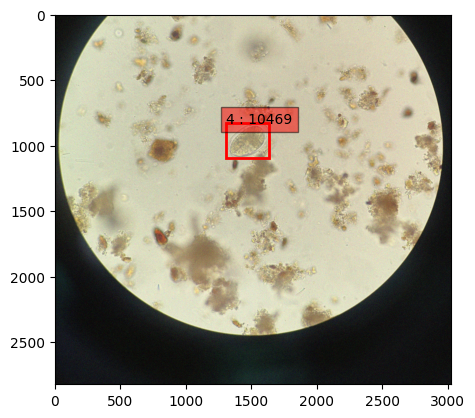

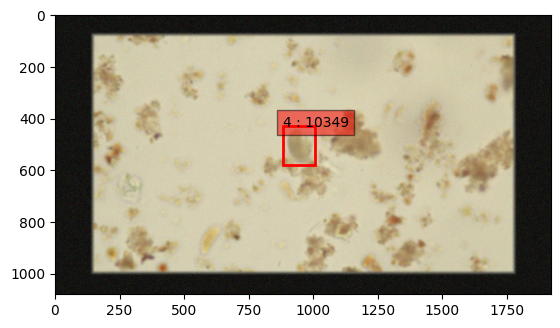

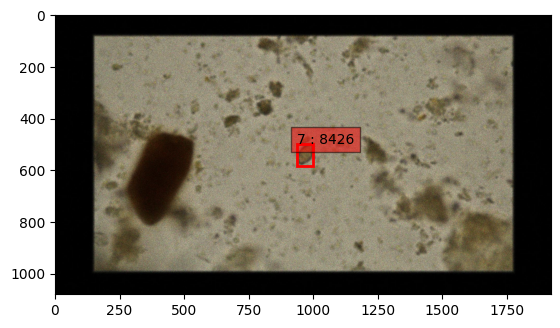

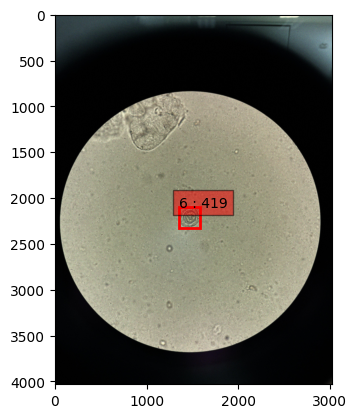

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# loop through all batches in the data loader
for i, (images, annotations) in enumerate(data_loader):
    # loop through all images and annotations in the batch
    for j in range(len(images)):
        # extract the image and annotation data
        image = images[j]
        annotation = annotations[j]

        # get the bounding boxes, labels, and category IDs for the objects in the image
        boxes = annotation['boxes'].cpu().numpy()
        labels = annotation['image_id']
        category_ids = annotation['category_id']


        # plot the image and draw the bounding boxes around the objects
        plt.imshow(np.transpose(image.cpu().numpy(), (1, 2, 0)))
        for box, label, category_id in zip(boxes, labels, category_ids):
            xmin, ymin, xmax, ymax = box
            plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                               fill=False, edgecolor='r', linewidth=2))
            plt.text(xmin, ymin, f'{category_id} : {label}', bbox=dict(facecolor='r', alpha=0.5))
        plt.show()


In [ ]:
"""for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    outputs = model(imgs)"""

#Fasteer R-CNN

In [ ]:
import torch.nn as nn

class FastRCNNPredictor(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(FastRCNNPredictor, self).__init__()
        self.cls_score = nn.Linear(in_channels, num_classes)
        self.bbox_pred = nn.Linear(in_channels, num_classes * 4)

        # Initialize the weights
        nn.init.normal_(self.cls_score.weight, std=0.01)
        nn.init.normal_(self.bbox_pred.weight, std=0.001)

    def forward(self, x):
        cls_logits = self.cls_score(x)
        bbox_pred = self.bbox_pred(x)

        return cls_logits, bbox_pred


#New New Run

In [ ]:
import torchvision
import torch.optim as optim
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import os

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

checkpoint_path = "/content/drive/MyDrive"

if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

checkpoint_file = os.path.join(checkpoint_path, "checkpoint_{epoch}.pt")

num_classes = len(my_dataset.coco.cats)
print(num_classes)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

def my_faster_rcnn_loss(outputs, targets):
    outputs = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in outputs.items()}
    targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
    loss_dict = model.roi_heads.forward(outputs, targets)
    return sum(loss_dict.values())
import tqdm

model.train()
model.to(device)
num_epochs = 3

for epoch in range(num_epochs):

    progress_bar = tqdm.tqdm(data_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")
    for images, targets in progress_bar:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        lr_scheduler.step()
        progress_bar.set_postfix(loss=losses.item())
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, checkpoint_file.format(epoch=epoch))
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


11


Epoch 1/3:   0%|          | 0/11000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1/3:   0%|          | 3/11000 [01:36<98:40:54, 32.30s/it, loss=0.252]


KeyboardInterrupt: ignored

In [ ]:
torch.save(model.state_dict(), 'model_final.pt')

NameError: ignored

#Prediction

In [ ]:
import torch
import torchvision.transforms as T
from PIL import Image
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# Load the saved model
num_classes = len(my_dataset.coco.cats)
model = fasterrcnn_resnet50_fpn(pretrained=False, num_classes=num_classes)
model.load_state_dict(torch.load('model_final.pt', map_location=torch.device('cpu')))

# Set the model to evaluation mode
model.eval()

# Load the test image
image = Image.open('0001.jpg').convert('RGB')

# Apply transformations to the image
transform = T.Compose([T.ToTensor()])
image = transform(image)

# Add a batch dimension to the image
image = image.unsqueeze(0)

# Make predictions
with torch.no_grad():
    predictions = model(image)

# Print the predicted classes and boxes
print(predictions)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


FileNotFoundError: ignored

#Run update

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a pre-trained model from torchvision
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
num_classes = 11 # number of categories in your dataset
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
import torch.optim as optim

# set device to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# construct an optimizer and a learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# train the model
model.to(device)
num_epochs = 10
for epoch in range(num_epochs):
    for images, targets in data_loader:
        # move data to device
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        # backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
    # update the learning rate
    lr_scheduler.step()
    
    # print the loss after each epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {losses.item():.4f}')


AttributeError: ignored

#Run the model

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model_instance_segmentation(num_classes):
    
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

num_classes = 2
num_epochs = 3
batch_size = 1
lr = 0.005
momentum = 0.9
weight_decay = 0.0005

model = get_model_instance_segmentation(num_classes).to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=lr, momentum=momentum, weight_decay=weight_decay)

# Use a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Use mixed-precision training
scaler = torch.cuda.amp.GradScaler()

len_dataloader = len(data_loader)

for epoch in range(num_epochs):
    model.train()
    i = 0    
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]

        with torch.cuda.amp.autocast():
            loss_dict = model(imgs, annotations)
            losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()

        scaler.scale(losses).backward()
        scaler.step(optimizer)
        scaler.update()

        lr_scheduler.step()

        print(f'Epoch: {epoch+1}/{num_epochs}, Iteration: {i}/{len_dataloader}, Loss: {losses:.4f}')
        


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 166MB/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` befor

Streaming output truncated to the last 5000 lines.
Epoch: 3/3, Iteration: 6001/11000, Loss: 0.4991
Epoch: 3/3, Iteration: 6002/11000, Loss: 0.4271
Epoch: 3/3, Iteration: 6003/11000, Loss: 0.3675
Epoch: 3/3, Iteration: 6004/11000, Loss: 0.2653
Epoch: 3/3, Iteration: 6005/11000, Loss: 0.4027
Epoch: 3/3, Iteration: 6006/11000, Loss: 0.3450
Epoch: 3/3, Iteration: 6007/11000, Loss: 0.4558
Epoch: 3/3, Iteration: 6008/11000, Loss: 0.3552
Epoch: 3/3, Iteration: 6009/11000, Loss: 0.2619
Epoch: 3/3, Iteration: 6010/11000, Loss: 0.5127
Epoch: 3/3, Iteration: 6011/11000, Loss: 0.1869
Epoch: 3/3, Iteration: 6012/11000, Loss: 0.2188
Epoch: 3/3, Iteration: 6013/11000, Loss: 0.1004
Epoch: 3/3, Iteration: 6014/11000, Loss: 0.1361
Epoch: 3/3, Iteration: 6015/11000, Loss: 0.2448
Epoch: 3/3, Iteration: 6016/11000, Loss: 0.2381
Epoch: 3/3, Iteration: 6017/11000, Loss: 0.2568
Epoch: 3/3, Iteration: 6018/11000, Loss: 0.3648
Epoch: 3/3, Iteration: 6019/11000, Loss: 0.3684
Epoch: 3/3, Iteration: 6020/11000, Lo

In [ ]:
torch.save(model.state_dict(), 'model_final.pt')

#rfff

In [ ]:
from torchvision.models import detection
import numpy as np
import argparse
import pickle
import torch
import cv2

ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", type=str, required=True,
	help="path to the input image")
ap.add_argument("-m", "--model", type=str, default="frcnn-resnet",
	choices=["frcnn-resnet", "frcnn-mobilenet", "retinanet"],
	help="name of the object detection model")
ap.add_argument("-l", "--labels", type=str, default="coco_classes.pickle",
	help="path to file containing list of categories in COCO dataset")
ap.add_argument("-c", "--confidence", type=float, default=0.5,
	help="minimum probability to filter weak detections")
args = vars(ap.parse_args())



In [ ]:
# set the device we will be using to run the model
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load the list of categories in the COCO dataset and then generate a
# set of bounding box colors for each class
CLASSES = pickle.loads(open(args["labels"], "rb").read())
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

In [ ]:
# initialize a dictionary containing model name and its corresponding 
# torchvision function call
MODELS = {
	"frcnn-resnet": detection.fasterrcnn_resnet50_fpn,
	"frcnn-mobilenet": detection.fasterrcnn_mobilenet_v3_large_320_fpn,
	"retinanet": detection.retinanet_resnet50_fpn
}

In [ ]:
# load the model and set it to evaluation mode
model = MODELS[args["model"]](pretrained=True, progress=True,
	num_classes=len(CLASSES), pretrained_backbone=True).to(DEVICE)
model.eval()

In [ ]:
# load the image from disk
image = cv2.imread(args["image"])
orig = image.copy()
# convert the image from BGR to RGB channel ordering and change the
# image from channels last to channels first ordering
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image.transpose((2, 0, 1))
# add the batch dimension, scale the raw pixel intensities to the
# range [0, 1], and convert the image to a floating point tensor
image = np.expand_dims(image, axis=0)
image = image / 255.0
image = torch.FloatTensor(image)
# send the input to the device and pass the it through the network to
# get the detections and predictions
image = image.to(DEVICE)
detections = model(image)[0]

In [ ]:
# loop over the detections
for i in range(0, len(detections["boxes"])):
	# extract the confidence (i.e., probability) associated with the
	# prediction
	confidence = detections["scores"][i]
	# filter out weak detections by ensuring the confidence is
	# greater than the minimum confidence
	if confidence > args["confidence"]:
		# extract the index of the class label from the detections,
		# then compute the (x, y)-coordinates of the bounding box
		# for the object
		idx = int(detections["labels"][i])
		box = detections["boxes"][i].detach().cpu().numpy()
		(startX, startY, endX, endY) = box.astype("int")
		# display the prediction to our terminal
		label = "{}: {:.2f}%".format(CLASSES[idx], confidence * 100)
		print("[INFO] {}".format(label))
		# draw the bounding box and label on the image
		cv2.rectangle(orig, (startX, startY), (endX, endY),
			COLORS[idx], 2)
		y = startY - 15 if startY - 15 > 15 else startY + 15
		cv2.putText(orig, label, (startX, y),
			cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS[idx], 2)
# show the output image
cv2.imshow("Output", orig)
cv2.waitKey(0)

#Fast Ai 

In [ ]:
!pip install fastai --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import fastai
from fastai.vision.all import *

print(fastai.__version__)

# add path ไปยัง Github ที่ clone มา
import sys
sys.path.append('Practical-Deep-Learning-for-Coders-2.0/Computer Vision/')

2.7.12


In [ ]:
imgs, label_bbox = get_annotations("/content/drive/MyDrive/Chula-ParasiteEgg-11/Chula-ParasiteEgg-11/labels.json")
img2bbox = dict(zip(imgs, label_bbox))

In [ ]:
def get_train_images(noop = None):
    return imgs

In [ ]:
images = get_train_images()

In [ ]:
funcs = [lambda o: o, lambda o: img2bbox[o][0], lambda o: img2bbox[o][1]]
item_tfms = [Resize(224)]
batch_tfms = [Rotate(), Flip(), Dihedral(), Normalize.from_stats(*imagenet_stats)]

wheat_datablock = DataBlock(
    blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
    splitter=RandomSplitter(valid_pct=0.2),
    get_items=get_train_images,
    getters=funcs,
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
    n_inp=1
)

In [ ]:
dls = wheat_datablock.dataloaders("/content/drive/MyDrive/Chula-ParasiteEgg-11/Chula-ParasiteEgg-11/data")
dls.c = 3

FileNotFoundError: ignored